In [55]:
from astrodendro import Dendrogram, pp_catalog
from astropy.io import fits
import matplotlib
#matplotlib.use('Qt5Agg')
from matplotlib import pyplot as plt
import numpy as np
import sys

np.set_printoptions(threshold=False)
#from make_dendro import make_dendrogram, make_prune_dendrogram
from scipy import ndimage
from matplotlib.ticker import ScalarFormatter
import pandas as pd
import os.path
import gc

import h5py
import glob
from scipy.spatial import cKDTree
import time

In [ ]:
# Need numba version >= 0.51 python: import numba, numba.__version__
#from clump_tools import *

In [56]:
# Define Variables
file = 'M2e3_mid'
outdir = ''
dendro_file = file+'_min_val1e2.fits' # min_value = 1e2

mh = 1.67e-24
kb = 1.38e-16
unit_base = {'UnitMagneticField_in_gauss':  1e+4,
             'UnitLength_in_cm'         : 3.08568e+18,
             'UnitMass_in_g'            :   1.989e+33,
             'UnitVelocity_in_cm_per_s' :      100}

helium_mass_fraction = 0.284 # Default mass fraction in Gizmo


def H2NumDensity(f):
    return f['PartType0']['Density'][:]*f['PartType0']['MolecularMassFraction'][:]*f['PartType0']['NeutralHydrogenAbundance'][:]*(1-helium_mass_fraction)/(2.0*mh)


In [57]:
# Load Data

f = h5py.File(file+'.hdf5', 'r')
den = f['PartType0']['Density'][:] #* unit_base['UnitMass_in_g'] / unit_base['UnitLength_in_cm']**3 # Need to remember to convert to match dendro
x = f['PartType0']['Coordinates'][:] # * unit_base['UnitLength_in_cm'] # [pc]
m = f['PartType0']['Masses'][:] # * unit_base['UnitMass_in_g'] # [Msun]
h = f['PartType0']['SmoothingLength'][:]
u = f['PartType0']['InternalEnergy'][:]
b = f['PartType0']['MagneticField'][:]
fmol = f['PartType0']['MolecularMassFraction'][:]
fneu = f['PartType0']['NeutralHydrogenAbundance'][:]
#t = f['PartType0']['Temperature'][:]
v = f['PartType0']['Velocities']

xvel = v[:,0] * unit_base['UnitVelocity_in_cm_per_s'] # [m/s]
yvel = v[:,1] * unit_base['UnitVelocity_in_cm_per_s']
zvel = v[:,2] * unit_base['UnitVelocity_in_cm_per_s']
xpos = x[:,0] * unit_base['UnitLength_in_cm'] # [pc]
ypos = x[:,1] * unit_base['UnitLength_in_cm'] # [pc]
zpos = x[:,2] * unit_base['UnitLength_in_cm'] # [pc]
#vol = f['PartType0']['cell_volume'][:] / unit_base['UnitLength_in_cm']**3 # [pc]
if 'PartType5' in f.keys():
    partlist = f['PartType5']['Coordinates'][:]
    partmasses = f['PartType5']['Masses'][:]
    partids = f['PartType5']['ParticleIDs'][:]
    
nh2 = unit_base['UnitMass_in_g']/ unit_base['UnitLength_in_cm']**3* den*fmol*fneu*(1-helium_mass_fraction)/(2.0*mh)

In [ ]:
partlist

In [ ]:
#a= unit_base['UnitMass_in_g']
#print(np.max(xpos), np.min(xpos))
print(a, unit_base['UnitMass_in_g']/unit_base['UnitLength_in_cm']**3 * den)
print(np.min(nh2), np.max(nh2))
#print(np.sum(den*fmol*fneu*(1-helium_mass_fraction)/(2.0*mh)), np.sum(nh2))

In [58]:
# Make/Load Dendrogram
if os.path.isfile(dendro_file):
    print("Found dendrogram", dendro_file)
    dendro = Dendrogram.load_from(dendro_file)
else:
    print("Warning: Need to make the fix to use kDTree to run dendrogram on Mac.") # See git repo branch, frontera/_yt_scripts/test_kdtree.py     
    start = time.time()
    d = Dendrogram.compute(nh2, min_value=1e4, min_delta=1e4, min_npix=100) # Original
    end = time.time()
    print("Done computing dendogram .... Time to make dendrogram [min] is", (end-start)/60.0)
    
print("Number of leaves is", len(dendro.leaves))
        

Found dendrogram M2e3_mid_min_val1e2.fits
Number of leaves is 202


In [19]:
# Test (test_dendroread.py)

# One leaf example
a = dendro.leaves[1]
mask = a.get_mask() # Return the mask (size is the same size as the full structure)
print("leaf index =", a.idx)
print("I am a leaf =", a.is_leaf)
print("leaf size =", a.get_npix())
print("Leaf max =", a.get_peak())
print("Check leaf max =", np.max(den[mask]))

leaf_masses = [] #done
leaf_maxden = [] #done
leaf_centidx = [] #done
leaf_centpos = [] #done
leaf_vdisp = []   #d 
leaf_vbulk = []   #d
leaf_evals = []   #d
leaf_evecs = []   #d
leaf_halfmass = [] #d
leaf_reff = []  #d
leaf_bmean = [] #d
leaf_mage = []  #d
leaf_ke = []    #d  
leaf_grave = [] #d
leaf_sink = []   #d
leaf_sinkallm = [] #d
leaf_sinkallid = [] #d
leaf_id = []  #d
leaf_cs = []   #ass-wieghted temperature
csconst = 0.18e5

nbin = np.logspace(3.5,5.5, 20)
radii_eq = np.zeros((len(dendro.leaves), len(nbin)))
v_com_x = np.zeros((len(dendro.leaves), len(nbin)))
v_com_y = np.zeros((len(dendro.leaves), len(nbin)))
v_com_z = np.zeros((len(dendro.leaves), len(nbin)))
vel_dist = np.zeros((len(dendro.leaves), len(nbin))) 
vel_dist_cp = np.zeros((len(dendro.leaves), len(nbin)))
radii_eq[radii_eq == 0] = 'nan'
vel_dist[vel_dist == 0] = 'nan'
vel_dist_cp[vel_dist_cp == 0] = 'nan'
v_com_x[v_com_x == 0] = 'nan'
v_com_y[v_com_y == 0] = 'nan'
v_com_z[v_com_z == 0] = 'nan'

def KE(xc, mc, vc, uc): 
    """ xc - array of positions 
        mc - array of masses 
        vc - array of velocities 
        uc - array of internal energies 
    """
    ## velocity w.r.t. com velocity of leaf
    v_bulk = np.average(vc, weights=mc,axis=0)
    v_well = vc - v_bulk
    vSqr = np.sum(v_well**2,axis=1)
    return (mc*(vSqr/2 + uc)).sum()

def BE(rc, mc, bc):
    """ xc - array of positions 
        mc - array of masses 
        bc - array of magnetic field strengths
    """
    ## magnetic energy
    bSqr = np.sum(np.sum(bc*bc, axis=1) * (rc**3/len(rc))) #unit_base['UnitLength_in_cm'])**3 *(unit_base['UnitMagneticField_in_gauss'])**2
    return bSqr.sum() / (8 * np.pi)

def PE(xc, mc, hc):
    """ xc - array of positions 
        mc - array of masses 
        hc - array of smoothing lengths 
        bc - array of magnetic field strengths
    """
    ## gravitational potential energy
    phic = pytreegrav.Potential(xc, mc, hc, G=4.301e4, theta=0.7) # G in code units
    return 0.5*(phic*mc).sum()

def Get_Shape(dxc):
    """ dxc - distance from center (density max) position 
    """
    ## Return shape               
    evals, evecs = np.linalg.eig(np.cov(dxc.T)) # This seems very slow ...
    sort_mask = np.argsort(-evals)
    return evals[sort_mask],evecs[sort_mask]
                  
start = time.time()
for leaf in dendro:
    if leaf.is_leaf:
        #print("Analyzing leaf ", leaf, " size", leaf.get_npix())
        mask = leaf.get_mask()
        mass = np.sum(m[mask])
        leaf_masses.append(mass)    # code units [msun]
        idx, maxd = leaf.get_peak() # [cm^-3]
        leaf_id.append(leaf.idx)
        leaf_centidx.append(idx)
        leaf_centpos.append(x[idx]) # code units [pc]
        leaf_maxden.append(maxd)
        
        # Get size information
        dx = x[mask]-x[idx]
        #evals, evecs = np.linalg.eig(np.cov(dx.T)) # This seems very slow ...
        #sort_mask = np.argsort(-evals)
        #evals, evecs = evals[sort_mask],evecs[sort_mask]
        
        evals, evecs = Get_Shape(dx)
        leaf_evals.append(evals)
        leaf_evecs.append(evecs)
                  
        r = np.sum(dx**2,axis=1)**0.5 # code units [pc]
        leaf_halfmass.append(np.median(r)) # code units [pc]
        leaf_reff.append(np.sqrt(5./3 * np.average(r**2,weights=m[mask]))) # code units [pc] 

        # Get velocity, ke information
        v_bulk = np.average(v[mask,:], weights=m[mask],axis=0)
        v_well = v[mask,:] - v_bulk
        vSqr = np.sum(v_well**2,axis=1)
        leaf_vdisp.append(np.sqrt((m[mask]*vSqr).sum()/mass)) # [m/s] 
        leaf_vbulk.append(v_bulk)  # code units [m/s]
        leaf_ke.append((m[mask]*(vSqr/2 + u[mask])).sum()) # code units [Msun m^2/s^2]
                                  
        # Get temp, coherence info          
        #coh = np.where(vel < csconst)
        #rcoher.append(np.sqrt(5./3 * np.average(r[coh]**2,weights=m[mask[coh]])))
        #cs = np.sqrt(kb*np.sum(m[mask]*t[mask])/mass/(2.33*mh))
        leaf_cs.append(csconst) #cgs
                  
        # Get grav, magnetic info
        #leaf_grave.append(PE(x[mask], m[mask], h[mask]))
        leaf_bmean.append(np.sqrt(np.average(b[mask,:]*b[mask,:], weights=m[mask],axis=0))) #*unit_base["UnitMagneticField_in_gauss"]
        leaf_mage.append(BE(r, m[mask], b[mask])) #code units
        
        sinkm = []
        sinkids = []
        numsinks = 0
        if np.any(partlist):
            for loc, s in enumerate(partlist):
                minx = np.array([np.min(x[mask,0]), np.min(x[mask,1]), np.min(x[mask,2])])
                maxx = np.array([np.max(x[mask,0]), np.max(x[mask,1]), np.max(x[mask,2])])
                if np.sum(s < maxx) + np.sum(s > minx) == 6:
                    sinkm.append(partmasses[loc])
                    sinkids.append(partids[loc])
                    numsinks += 1
       
        leaf_sink.append(numsinks)  
        leaf_sinkallm.append(sinkm) # code units
        leaf_sinkallid.append(sinkids) # code units
        
print("Need to add temperature calculation, update cs")
end = time.time()
print("Done computing properties...  / time is [min]=", (end-start)/60.0)

leaf index = 161
I am a leaf = True
leaf size = 1308
Leaf max = ((477965,), 2240576.75)
Check leaf max = 154553.83
Need to add temperature calculation, update cs
Done computing properties...  / time is [min]= 8.406984396775563


In [ ]:
# Test Code


nbin = np.logspace(3.5,6.5, 16)
radii_eq = np.zeros(16)
veldisp = np.zeros(16)
radii_eq[radii_eq == 0] = 'nan'

mask = leaf.get_mask()
mass = np.sum(m[mask])
masses.append(mass) # In Msun
idx, maxd = leaf.get_peak()
centidx.append(idx)
centpos.append(x[idx])
maxden.append(maxd)
        #coords = np.vstack((rx,ry,rz)).T

dx = x-x[idx]
r = np.sum(dx**2, axis=1)**0.5
mask = np.logical_and(mask, r<0.5)  # Truncate leaf 

valid_densites = nh2[mask]
dx = x[mask]-x[idx]
r = np.sum(dx**2, axis=1)**0.5

for j in range(len(nbin)):
   
    #ind = (nh2[mask]<nbin[j]) & (nh2[mask] > nbin[j-1])
    ind = (nh2[mask] > nbin[j])
    #print(j, ind)
    if np.max(ind):
        #print(j, len(np.where(ind == True)[0]))
        evals, evecs = np.linalg.eig(np.cov(dx[ind].T)) # This seems very slow ...
        #print(evals)
        mass = np.sum(m[mask][ind])
        px = np.sum(m[mask][ind]*xvel[mask][ind])
        py = np.sum(m[mask][ind]*yvel[mask][ind])
        pz = np.sum(m[mask][ind]*zvel[mask][ind])
        vxcom = px/mass
        vycom = py/mass
        vzcom = pz/mass
        veldisp[j] = np.sqrt((np.sum(m[mask][ind]*np.square(xvel[mask][ind]-vxcom)) + 
                          np.sum(m[mask][ind]*np.square(yvel[mask][ind]-vycom)) + 
                          np.sum(m[mask][ind]*np.square(zvel[mask][ind]-vzcom)))/mass)
        vol_iso = evals[0]*evals[1]*evals[2]
        radii_eq[j] = reff.append(np.sqrt(5./3 * np.average(r[ind]**2,weights=m[mask][ind]))) #np.cbrt(vol_iso)
    
fig, ax = plt.subplots()
ax.plot(radii_eq,nbin, 'o')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.001,0.05])
plt.show()    


fig, ax = plt.subplots()
ax.plot(radii_eq,veldisp, 'o')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.001,0.05])
plt.show()   

print(veldisp)

In [ ]:
ind1 = np.where(nh2[mask]< 1e4)[0]
ind2 = np.where(nh2[mask] > 1e4)[0]

ind = (nh2[mask] < 1e4) & (nh2[mask] > 1e3)
print(np.max(ind))
print(np.mean(r[ind]), np.mean(r[ind2]))

np.reverse(np.array[0,1])

In [90]:
# Copy code from profile generation function
import copy as cp
snapshot_no=300 # temp
szbin = 12
leaves = dendro.leaves
loop_length = len(leaves)
leaf_ids = np.zeros(loop_length)
nbin = np.logspace(3.5,6.5, szbin)
radii_eq = np.zeros((loop_length, szbin))
veldisp = np.zeros((loop_length, szbin))
n_part = np.zeros((loop_length, szbin))
radii_eq[radii_eq == 0] = 'nan'

allden = []   # Store all relevant densities
allradii = [] # Store all relevant radii

plotleaf = False # Much faster without
saveall = False  # Store all densities and radii values in the mask

xvel = v[:,0]
yvel = v[:,1]
zvel = v[:,1]

begin = time.time()
for i in range(loop_length): #get leaf, find profiles
        start = time.time()
        leaf_ids[i] = str(snapshot_no)+str(leaves[i].idx)
        print("Leaf "+str(i)+" of "+str(loop_length))
        #print("Levels", leaves[i].level)
        center = leaves[i].get_peak()[0] #find center
        self_id = leaves[i].idx #identify leaf of focus
        
        mask = leaves[i].get_mask() #np.zeros(len(nh2)) # New structure
        if plotleaf:
            fig, ax = plt.subplots()
            ax.scatter(x[mask,0], x[mask,1], alpha=0.1,s=1)
            
        leafden = nh2[mask]
        minleaf = np.min(leafden)
        

        dx = x-x[center]   #location of peak in indicy
        r = np.sqrt(np.sum(dx**2, axis=1))
        masksz = (r < 0.5) 
        
        # cap all other densities at minimum of target leaf
        leaf_nh2 = cp.deepcopy(nh2)
        leaf_nh2[leaf_nh2 > minleaf] = minleaf 
        leaf_nh2[mask] = nh2[mask]

        # Crop data arrays
        leaf_nh2 = leaf_nh2[masksz] 
        r = r[masksz]
        smv = v[masksz,:]
        if plotleaf:
            #fig, ax = plt.subplots()
            ax.scatter(x[masksz,0], x[masksz,1], alpha=0.1,s=2)
            plt.savefig('Leaf_%i_test.png' %i)
            plt.close()
        
        for j in range(len(nbin)):  
            ind = (leaf_nh2 > nbin[j])
            if len(leaf_nh2[ind]) > 1:
                #print(" nbin, ", j)
                #evals, evecs = np.linalg.eig(np.cov(dx[ind].T)) # This seems very slow ...
                mass = np.sum(leaf_nh2[ind])
                v_com = np.average(smv[ind,:], weights=leaf_nh2[ind],axis=0)
                v_well = smv[ind,:] - v_com
                vSqr = np.sum(v_well**2,axis=1)
                veldisp[i,j] = np.sqrt((leaf_nh2[ind]*vSqr).sum()/mass) # [m/s]
                radii_eq[i,j] = np.sqrt(5./3 * np.average(r[ind]**2)) #,weights=leaf_nh2[mask2][ind])) #np.cbrt(vol_iso)
                n_part[i,j] = len(r[ind])
                #ax.scatter(dx[:,0], dx[:,1], alpha=0.1,s=1)
        
        end = time.time()
        print(" Time to complete = [min]", (end-start)/60.)

print("Total time = ", (end - begin)/60.0)

Leaf 0 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 Time to complete = [min] 0.03670175472895305
Leaf 1 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 nbin,  4
 nbin,  5
 nbin,  6
 nbin,  7
 nbin,  8
 nbin,  9
 nbin,  10
 Time to complete = [min] 0.017222766081492105
Leaf 2 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 nbin,  4
 nbin,  5
 nbin,  6
 Time to complete = [min] 0.02307729721069336
Leaf 3 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 nbin,  4
 nbin,  5
 nbin,  6
 nbin,  7
 nbin,  8
 nbin,  9
 nbin,  10
 nbin,  11
 Time to complete = [min] 0.05743408203125
Leaf 4 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 nbin,  4
 nbin,  5
 nbin,  6
 nbin,  7
 nbin,  8
 nbin,  9
 nbin,  10
 nbin,  11
 Time to complete = [min] 0.02937153180440267
Leaf 5 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 nbin,  4
 Time to complete = [min] 0.02225559949874878
Leaf 6 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 Time to complete = [min] 0.04241068363189697
Leaf 7 of 202
 nbin,  0
 nbin,  1
 nb

 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 nbin,  4
 nbin,  5
 nbin,  6
 nbin,  7
 nbin,  8
 nbin,  9
 Time to complete = [min] 0.10165338516235352
Leaf 67 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 nbin,  4
 nbin,  5
 nbin,  6
 nbin,  7
 Time to complete = [min] 0.11831056674321493
Leaf 68 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 nbin,  4
 nbin,  5
 nbin,  6
 nbin,  7
 Time to complete = [min] 0.1225970983505249
Leaf 69 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 nbin,  4
 nbin,  5
 nbin,  6
 nbin,  7
 nbin,  8
 nbin,  9
 nbin,  10
 nbin,  11
 Time to complete = [min] 0.09209361473719278
Leaf 70 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 nbin,  4
 nbin,  5
 nbin,  6
 nbin,  7
 Time to complete = [min] 0.09603698253631592
Leaf 71 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 nbin,  4
 nbin,  5
 Time to complete = [min] 0.0838915983835856
Leaf 72 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 nbin,  4
 nbin,  5
 nbin,  6
 nbin,  7
 nbin,  8
 nbin,  9
 Time to compl

 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 nbin,  4
 nbin,  5
 Time to complete = [min] 0.190569802125295
Leaf 129 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 Time to complete = [min] 0.146872611840566
Leaf 130 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 nbin,  4
 Time to complete = [min] 0.1242761492729187
Leaf 131 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 Time to complete = [min] 0.19671343167622884
Leaf 132 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 nbin,  4
 nbin,  5
 Time to complete = [min] 0.05763528347015381
Leaf 133 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 Time to complete = [min] 0.04580820401509603
Leaf 134 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 Time to complete = [min] 0.04839688539505005
Leaf 135 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 nbin,  4
 Time to complete = [min] 0.189359982808431
Leaf 136 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 Time to complete = [min] 0.12117383480072022
Leaf 137 of 202
 nbin,  0
 nbin,  1
 nbin,  2

 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 nbin,  4
 Time to complete = [min] 0.05626271963119507
Leaf 192 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 Time to complete = [min] 0.050970816612243654
Leaf 193 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 Time to complete = [min] 0.07376758257548015
Leaf 194 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 nbin,  4
 nbin,  5
 nbin,  6
 nbin,  7
 nbin,  8
 nbin,  9
 nbin,  10
 nbin,  11
 Time to complete = [min] 0.10447927316029866
Leaf 195 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 Time to complete = [min] 0.058085501194000244
Leaf 196 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 Time to complete = [min] 0.06899193127950033
Leaf 197 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 nbin,  4
 Time to complete = [min] 0.12201674779256184
Leaf 198 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 Time to complete = [min] 0.046500551700592044
Leaf 199 of 202
 nbin,  0
 nbin,  1
 nbin,  2
 nbin,  3
 Time to complete = [min] 0.026087796688079833
Leaf 200 of 202
 nbin,

[214.03611755 154.97422791  47.71263504 ...   0.           0.
   0.        ]
[0.16265049 0.07694006 0.02115041 ...        nan        nan        nan]


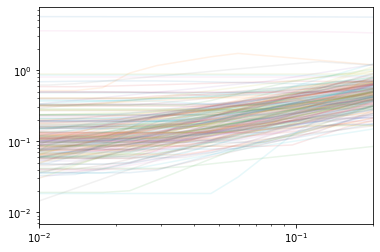

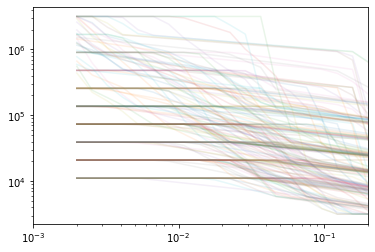

In [231]:
idx = 3
print(veldisp[0,:])
print(radii_eq[0,:])
            
fig, ax = plt.subplots()
for i in range(loop_length):
    #ax.plot(radii_eq[i,:], veldisp[i,:], alpha=0.1)#,s=100)
    ax.plot(10**size_grid, 10**i_veldisp_interp[i][:], alpha=0.1)
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.01, 2e-1])
#ax.set_ylim([10, 1e4])
plt.show()

fig, ax = plt.subplots()
for i in range(loop_length):
    #ax.plot(radii_eq[i,:], nbin, alpha=0.1)#,s=100)
    ax.plot(10**size_grid, 10**i_density_interp[i][:], alpha=0.1)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.001, 2e-1])
#ax.set_ylim([1e3, 1e7])
plt.show()



In [67]:
idx = 19
print(len(radii_eq), leaves[idx].get_peak())
print(np.max(leaf_nh2), np.max(leaf_nh2[mask2]))
tmp = leaf_nh2[mask2]

#order = np.argsort(allden)
print(len(tmp), len(r))
fig, ax = plt.subplots()
#ax.scatter(r, tmp, alpha=0.1,s=2)
ax.scatter(x[mask2,0],x[mask2,1],alpha=0.1, s=2)

#ax.set_yscale('log')
#ax.set_xscale('log')
#ax.set_xlim([0.0001, 5e-1])
plt.show()

fig, ax = plt.subplots()
ax.scatter(allradii[idx], allden[idx], alpha=0.1,s=2)
ax.scatter(radii_eq[idx,:],nbin,alpha=1, s=100)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.001, 5e-1])
plt.show()

fig, ax = plt.subplots()
ax.scatter(radii_eq[idx,:], veldisp[idx,:], alpha=1,s=100)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.001, 5e-1])
plt.show()


202 ((1226829,), 802056.4375)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 16806 but corresponding boolean dimension is 2453137

In [226]:
size_grid = np.log10(np.logspace(np.log10(2e-3), np.log10(2e-1), 20))
i_density_interp = []
i_veldisp_interp = []
leaf_rpow = []
leaf_rcoh = []

for i in range(len(leaf_cs)):
        i_size = np.log10(radii_eq[i][::-1])
        i_density = np.log10(nbin[::-1])
        veldisp[i][::-1][veldisp[i][::-1]<1] = 0
        i_veldisp = np.log10(veldisp[i][::-1]/1e3) #Convert to km/s
        mask_clean = np.isfinite(i_size)&np.isfinite(i_density)&np.isfinite(i_veldisp)
        i_density_interp.append(np.interp(size_grid, i_size[mask_clean], i_density[mask_clean]))
        i_veldisp_interp.append(np.interp(size_grid, i_size[mask_clean], i_veldisp[mask_clean]))
        idx = np.where(np.array(i_veldisp_interp[i]) < np.log10(np.sqrt(3.0)*leaf_cs[i]/1e5))[0]
        if idx.size > 0: 
            leaf_rcoh.append(size_grid[np.max(idx)])
        else:
            leaf_rcoh.append(0.0)

        poly = np.polyfit(size_grid[:-9],i_density_interp[i][:-9], 1, rcond=None, full=False, w=None, cov=False) #1 = Degree of fit
        leaf_rpow.append(poly[0])


/Users/so8266/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


In [236]:
prop_file = 'temp_leaves.csv'
leaf_count = len(leaf_masses) # Here just one snapshot
combined_all = np.empty(shape=(leaf_count,22), dtype=object)
for leaf in range(leaf_count):
    combined_all[leaf][0] = leaf_ids[leaf] #
    combined_all[leaf][1] = i_density_interp[leaf]    # interpolated log density
    combined_all[leaf][2] = i_veldisp_interp[leaf]    # interpolated log velocity Note:  compare with droplets, need to convert to sigtot = (signt^2 + cs^2)**0.5
    combined_all[leaf][3] = leaf_reff[leaf]   
    combined_all[leaf][4] = leaf_vdisp[leaf]  
    combined_all[leaf][5] = leaf_masses[leaf]  
    combined_all[leaf][6] = 10**leaf_rcoh[leaf]   
    combined_all[leaf][7] = leaf_rpow[leaf]
    combined_all[leaf][8] = leaf_vbulk[leaf]
    combined_all[leaf][9] = leaf_centpos[leaf]
    combined_all[leaf][10] = leaf_centidx[leaf][0]
    combined_all[leaf][11] = leaf_ke[leaf]
    #combined_all[leaf][12] = leaf_grave[leaf]
    combined_all[leaf][13] = leaf_sink[leaf]
    combined_all[leaf][14] = leaf_maxden[leaf]
    combined_all[leaf][15] = leaf_evals[leaf]
    combined_all[leaf][16] = leaf_evecs[leaf]
    combined_all[leaf][17] = leaf_halfmass[leaf]
    combined_all[leaf][18] = leaf_bmean[leaf]
    combined_all[leaf][19] = leaf_mage[leaf]
    combined_all[leaf][20] = leaf_sinkallm[leaf]
    combined_all[leaf][21] = leaf_cs[leaf]

np.set_printoptions(threshold=sys.maxsize)
save_df = pd.DataFrame(combined_all, columns = ['ID','Density [cm^-3]','Dispersion [m/s]', 'Reff [pc]', 'LeafDisp [m/s]', 'LeafMass [msun]', 'CoherentRadius [pc]',
                                                'DensityIndex','V Bulk [m/s]','Center Position [pc]','Center index','LeafKe', 'LeafGrav', 'Num. Sinks',
                                                'Max Den [cm^-3]', 'Eigenvals [pc]', 'Eigenvecs', 'Half Mass R[pc]', 'Mean B [T]', 'Mag. Energy', 'Sink Masses [Msun]',
                                                'Sound speed [cm/s]'])
print("Saving cores in ", prop_file)
print("Total number of leaves = ", leaf_count)
save_df.to_csv(prop_file,index=False)

Saving cores in  temp_leaves.csv
Total number of leaves =  202


In [240]:
leaf_centidx[2][0]

643940

In [ ]:
fig, ax = plt.subplots()
nbin = np.logspace(3.5,5.5, 20)

for i in range(loop_length):
    ax.plot(radii_eq[i,:], nbin, alpha=0.1)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.001, 5e-1])
plt.show()


fig, ax = plt.subplots()

for i in range(loop_length):
    ax.plot(radii_eq[i,:], veldisp[i,:]/2e4, alpha=0.1)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.001, 5e-1])
plt.show()

fig, ax = plt.subplots()

for i in range(loop_length):
    ax.plot(radii_eq[i,:], n_part[i,:], alpha=0.1)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.001, 5e-1])
plt.show()



In [ ]:
fig = plt.figure(figsize=(15,5))
p2 = dendro.plotter()

ax2 = fig.add_subplot(2, 1, 1)
p2.plot_tree(ax2, color='black')
#ax2.hlines(3.5, *ax2.get_xlim(), color='b', linestyle='--')
ax2.hlines(1e4, *ax2.get_xlim(), color='b', linestyle='--')
ax2.hlines(2e4, *ax2.get_xlim(), color='b', linestyle='--')
ax2.set_yscale('log')
ax2.set_xlabel("Structure")
ax2.set_ylabel("Flux")
ax2.set_title("Min_value = 1e4")

dendro1e4 = Dendrogram.load_from("M2e3_mid.fits") #min_value = 1e4

p3 = dendro1e4.plotter()

ax3 = fig.add_subplot(2, 1, 2)
p3.plot_tree(ax3, color='black')
ax3.hlines(1e4, *ax3.get_xlim(), color='b', linestyle='--')
ax3.hlines(2e4, *ax3.get_xlim(), color='b', linestyle='--')
ax3.set_yscale('log')
ax3.set_xlabel("Structure")
ax3.set_ylabel("Flux")
ax3.set_title("Min_value = 1e2")
ax3.set_ylim(*ax2.get_ylim())

plt.show()

In [ ]:
# Make some plots
plt.close('all')

print("Mean, median masss =", np.mean(masses), np.median(masses))
print("Mean B field (muG) =", np.mean(b)*1e6, np.median(b)*1e6)
fig, ax = plt.subplots()
#ax.hist(np.log10(leaf_masses))
mage_unit = (np.array(leaf_mage)*(1e4)**2 *(3.09e18)**3)
ke_unit = np.float128(np.array(leaf_ke))*np.float128(2e33)*np.float128(1e2**2)
ax.hist(mage_unit)# * (unit_base['UnitMagneticField_in_gauss'])**2))
#ax.hist(mage_unit)
#ax.hist(ke_unit)
ax.hist(ke_unit)
ax.set_xlabel('Log BE/ KE')
ax.set_xscale('log')
#plt.savefig("Logmass.png")
#plt.show()
        
fig, ax = plt.subplots()
#ax.hist(np.log10(np.sqrt(8*np.pi*np.array(leaf_mage)) * unit_base['UnitMagneticField_in_gauss'] * 1e6))
ax.hist(np.array(leaf_vdisp)*100./(cs))
ax.set_xlabel('vrms/cs')
ax.set_xscale('log')
#plt.savefig("Logmass.png")
#plt.show()

rat1 = np.float128(np.array(leaf_mage))*np.float128(unit_base['UnitMagneticField_in_gauss']**2) #*(4.0/3.0*np.pi)*np.array(leaf_reff)**3
rat2 = np.float128(np.array(leaf_ke))*np.float128(unit_base['UnitMass_in_g']*unit_base['UnitVelocity_in_cm_per_s']**2)

print("min/max rat =", np.min(rat1), np.max(rat2))

fig, ax = plt.subplots()
ax.hist(np.log10(rat1/rat2))
ax.set_xlabel('Log BE/KE')
        
fig, ax = plt.subplots()
print("Mean, median size (semi-major axes) =", np.mean(major), np.median(major))
ax.hist(np.log10(leaf_evals[:,0]),histtype='step')
ax.hist(np.log10(leaf_evals[:,1]),histtype='step')
ax.hist(np.log10(leaf_evals[:,2]),histtype='step')

plt.show()

if 0:
    fig, ax = plt.subplots()
    ax.scatter(x[:,0][::5], x[:,1][::5],s=0.5, alpha=0.01,c='black')
    plt.xlim([12,18])
    plt.ylim([12,18])
    for leaf in dendro:
        if leaf.is_leaf:
            mask = leaf.get_mask()
            ax.scatter(x[mask,0][::10], x[mask,1][::10],s=1, alpha=0.1)

    ax.set_xlabel('X [pc]')
    ax.set_ylabel('Y [pc]')
    plt.show()

    for leaf in dendro:
        if leaf.is_leaf:
            fig, ax = plt.subplots()
            mask = leaf.get_mask()
            ax.scatter(x[:,0][::10], x[:,1][::10],s=1, alpha=0.1, c = 'grey')
            ax.scatter(x[mask,0][:], x[mask,1][:],s=1, alpha=0.1, c='blue')
            cent=leaf.get_peak()[0]
            ax.set_xlim([x[cent,0] - 0.2, x[cent,0]+0.2])
            ax.set_ylim([x[cent,1] - 0.2, x[cent,1]+0.2])
            plt.savefig('Leaf_indiv_%i.png' %leaf.idx)


#fig = plt.figure()
#ax = fig.add_subplot()#(projection='3d')
# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
#for leaf in dendro:
#    if leaf.is_leaf:
#        mask = leaf.get_mask()
#        ax.scatter3d(x[mask,0][::5], x[mask,1][::5], x[mask,2][::5],s=1)

#ax.set_xlabel('X [pc]')
#ax.set_ylabel('Y [pc]')
#ax.set_zlabel('Z [pc]')

#plt.show()

In [ ]:
print("Mean, median masss =", np.mean(masses), np.median(masses))
fig, ax = plt.subplots()
ax.hist(np.log10(np.divide(masses,1e-3)))
#plt.savefig("Logmass.png")
plt.show()

In [ ]:
np.min(leaf_reff)**3 *np.min(leaf_masses)

In [ ]:
np.max(u), np.min(u), np.median(np.abs(v))**2*np.median(m)

In [ ]:
b_well = b[mask] - np.average(b[mask], weights=m[mask],axis=0)
print("mean b =", np.average(b[mask], weights=m[mask],axis=0)*1e4*1e6)
np.sum(np.sum(b_well*b_well, axis=1) * (r*unit_base['UnitLength_in_cm'])**3 /len(r))*(unit_base['UnitMagneticField_in_gauss'])**2

In [ ]:
leaf_grave, leaf_ke
temp.append(5)
temp.append(6)
print(temp)
np.shape(temp)

In [ ]:
print(np.mean(np.array(leaf_vdisp))*100.0)
print(np.mean(leaf_vxcom))

In [ ]:
def test(xc): 
    """ xc - array of positions 
        mc - array of masses 
        vc - array of velocities 
        uc - array of internal energies 
    """
    return np.array([1,2,3]), np.array([1,2,3])

a, b = test(x[mask])
print(a,b)

In [ ]:
print(np.mean(np.array(mage_unit)/np.array(ke_unit)))
print(np.max(np.sqrt(2.0/np.array(leaf_masses)*ke_unit/2e33))/1e5)



In [ ]:
np.median(leaf_veldisp)

In [ ]:
print(np.sum(leaf_sink), len(partlist))

In [ ]:
leaf_veldisp

In [ ]:
print(leaf_sinkallpos)